# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.253421,False,-0.075338
1,-1.307667,False,-1.607124
2,-1.511298,False,-1.843642
3,-1.326911,False,-2.326025
4,0.217360,False,-0.741063
...,...,...,...
995,-1.079517,True,4.103752
996,-1.456861,False,-3.353512
997,0.235841,True,4.579066
998,0.076628,False,-0.916159


<AxesSubplot:xlabel='v0'>

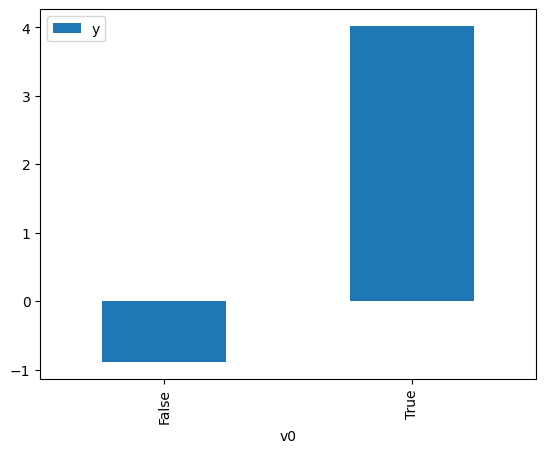

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

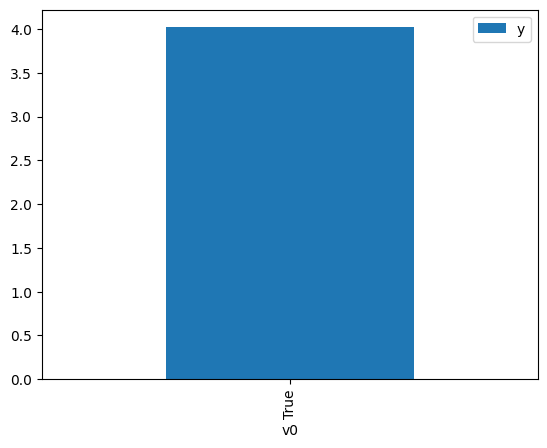

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.257634,False,-0.553131,0.772663,1.294225
1,-0.645825,False,-0.321828,0.643361,1.554336
2,-0.383345,False,0.553655,0.578893,1.727436
3,-1.247452,False,-1.921266,0.770806,1.297343
4,0.450689,False,0.317834,0.366961,2.725083
...,...,...,...,...,...
995,-0.796637,False,-1.341186,0.678334,1.474201
996,-0.834450,False,-1.717455,0.686816,1.455995
997,-1.039332,False,-1.052645,0.730546,1.368839
998,-1.677686,False,-2.779087,0.840010,1.190461


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.621381,True,5.116336,0.362466,2.758878
1,-0.954664,True,3.162908,0.287054,3.483666
2,-1.341518,True,4.688111,0.212444,4.707134
3,-2.394587,True,2.193829,0.083132,12.029112
4,0.844425,True,5.274384,0.721703,1.385612
...,...,...,...,...,...
995,0.585564,True,5.975241,0.664835,1.504133
996,-2.392109,True,2.552650,0.083327,12.000846
997,-0.808953,True,5.108415,0.318890,3.135873
998,-0.378498,True,6.949859,0.422331,2.367810


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.900
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                              4506.
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        23:13:44   Log-Likelihood:                         -1406.3
No. Observations:                1000   AIC:                                      2817.
Df Residuals:                     998   BIC:                                      2826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0167      0.023     43.693      0.000       0.971       1.062
x2             4.9931      0.055     89.988      0.000       4.884       5.102
==============================================================================
Omnibus:                        3.267   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                3.296
Skew:                           0.084   Prob(JB):                        0.192
Kurtosis:                       3.225   Cond. No.                         2.43
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""